# **SECTION 2 - PROJECT**

# Health Insurance Cross Sell Prediction 
### Predict Health Insurance Owners' who will be interested in Vehicle Insurance

1. id - 고객의 ID 
2. Gender -	성별  
3. Age - 나이  
4. Driving_License - 0 : 운전면허 없음 / 1 : 운전면허 있음
5. Region_Code - 고객이 사는 지역코드
6. Previously_Insured	
1 : 이미 차량보험 있음 / 0 : 차량보험 없음
7. Vehicle_Age - 차량의 노후정도
8. Vehicle_Damage  
1 : 과거에 차량이 파손된 적이 있음 / 0 : 차량이 파손된 적이 없음
9. Annual_Premium	- 고객이 연도에 보험료로 지불해야 하는 금액 
10. PolicySalesChannel - 고객에게 연락하는 채널에 대한 익명화된 코드, 즉. 다양한 상담원, 우편, 전화, 직접 방문 등  
11. Vintage -	고객이 회사와 연결되어 있었던 일 수
12. **Response - 1 : Customer is interested / 0 : Customer is not interested**

귀하의 클라이언트는 고객에게 건강 보험을 제공한 보험 회사입니다. 이제 그들은 작년의 보험 계약자(고객)가 회사에서 제공한 차량 보험에 관심을 가질지 여부를 예측하는 모델을 구축하는 것이 목표

고객이 자동차 보험에 관심을 가질지 여부를 예측하는 모델을 구축하는 것은 회사에 매우 도움이 됩니다. 그 이유는 그에 따라 해당 고객에게 다가가 비즈니스 모델과 수익을 최적화하기 위한 커뮤니케이션 전략을 계획할 수 있기 때문입니다.

In [ ]:
!pip install category_encoders
!pip install -U scikit-learn
!pip install PDPbox
!pip install shap
!pip install eli5
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/train.csv")      # 데이터
train_F = pd.read_csv("/content/train.csv")    # 최종 데이터

df.head()
print(df.shape)

(381109, 12)


## 1) 데이터 선정 이유
향후에 어떤 방식으로 고객에게 접근해야 보험에 가입을 할지를 예측하기 위해 이 데이터를 선택함
### 분류 / 회귀
차량보험에 관심을 가질지 안가질지를 판단하는 **이진분류문제**이다
### 가설
보험료의 가격이 차량 보험 관심에 영향을 준다

## 2) 데이터 분석

In [ ]:
# target의 수와 비율
pd.concat([pd.DataFrame(df[['Response']].value_counts(), columns = ['count']), pd.DataFrame(df[['Response']].value_counts(normalize=True), columns = ['rate'])], axis = 1)

# 기준모델 0.877437 
# 클래스가 불균형한 분류 문제
# 타겟의 비율이 70%를 넘으므로 클래스 불균형을 맞춘 후 평가지표로 재현율 사용, ROC curve, AUC, f1 score 참고

,count,rate
Response,,
0,334399,0.877437
1,46710,0.122563


In [ ]:
# 결측치 확인
pd.DataFrame(df.isnull().sum(), columns=["결측치 개수"])

,결측치 개수
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [ ]:
# 중복값 확인
pd.DataFrame(df.duplicated(list(df.columns)).value_counts(), columns=['중복값 개수'])

,중복값 개수
False,381109


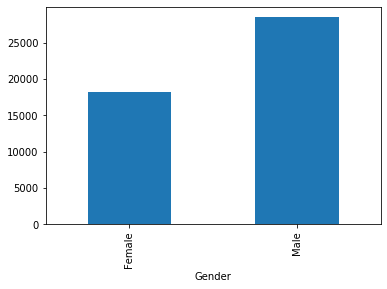

In [ ]:
# 성별에 따른 응답 비율
df.groupby('Gender')['Response'].sum().plot(kind='bar')

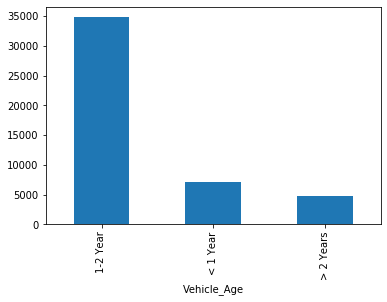

In [ ]:
# 차량의 노후정도에 따른 응답 비율
df.groupby('Vehicle_Age')['Response'].sum().plot(kind='bar')

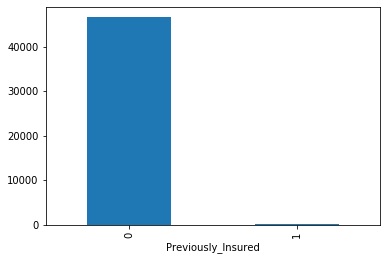

In [ ]:
# 차량보험 여부에 따른 응답 비율
df.groupby('Previously_Insured')['Response'].sum().plot(kind='bar')

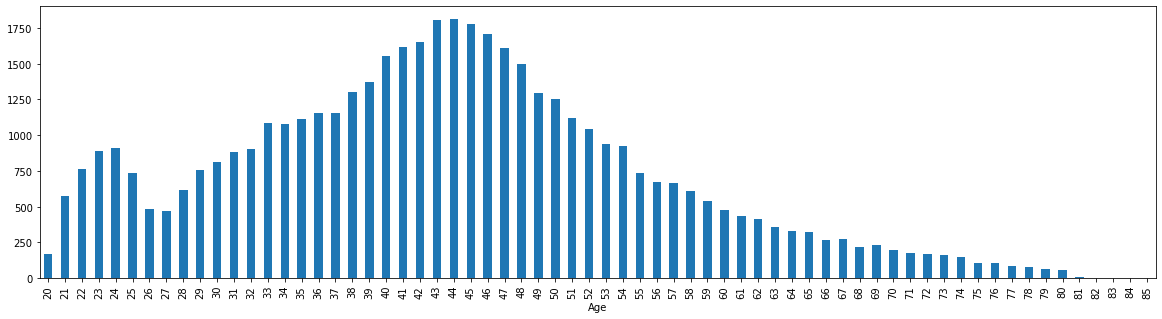

In [ ]:
# 나이별 가입수 그래프
df.groupby('Age')['Response'].sum().plot(kind='bar', figsize=(20, 5))
# 그래프를 보아 40대에서 가장 높은 수치를 보여준다

In [ ]:
# 높은 cardinality인 특성
len(df['Region_Code'].unique()), len(df['Policy_Sales_Channel'].unique())

(53, 155)

In [ ]:
# 나이대별 분류
def trans_Age(n):       
  for i in range(20,90,10):
    if (n >= i) & (n < i+10):
      n = i
  return n

# 회사와 연결되어 있던 개월 수 
def trans_V(n):
  for i in range(0, 360, 30):
    if (n >= i) & (n < i+30):
      n = i / 30
  return int(n)

In [ ]:
# 전처리
def eng(data):
  data['Vehicle_Damage'] = data['Vehicle_Damage'].replace({'Yes':1, 'No':0})
  
  data['Region_Code'] = data['Region_Code'].astype(int)
  data['Annual_Premium'] = data['Annual_Premium'].astype(int)
  data['Policy_Sales_Channel'] = data['Policy_Sales_Channel'].astype(int)

  data.drop(['id', 'Region_Code', 'Policy_Sales_Channel'],axis=1,inplace=True)    # 단순 번호인 ID와 지역코드, 판매 종류 코드 삭제

  data['Age'] = data['Age'].apply(trans_Age)
  data['Vintage'] = data['Vintage'].apply(trans_V)
  return data

eng(df)
eng(train_F)

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
0,Male,40,1,0,> 2 Years,1,40454,7,1
1,Male,70,1,0,1-2 Year,0,33536,6,0
2,Male,40,1,0,> 2 Years,1,38294,0,1
3,Male,20,1,1,< 1 Year,0,28619,6,0
4,Female,20,1,1,< 1 Year,0,27496,1,0
...,...,...,...,...,...,...,...,...,...
381104,Male,70,1,1,1-2 Year,0,30170,2,0
381105,Male,30,1,1,< 1 Year,0,40016,4,0
381106,Male,20,1,1,< 1 Year,0,35118,5,0
381107,Female,60,1,0,> 2 Years,1,44617,2,0


In [ ]:
from sklearn.model_selection import train_test_split

# 타겟은 가입여부 'Response'
target = 'Response'

# train 데이터를 훈련/검증/테스트로 분리
train, test = train_test_split(df, test_size=0.15, stratify=df[target], random_state=2)
train, val = train_test_split(df, test_size=0.25, stratify=df[target], random_state=2)

# 타겟 / 특성 분리
features = train.drop(columns=[target]).columns

X_train_F = train_F[features]   # 최종훈련데이터
y_train_F = train_F[target]

X_train = train[features]       # 훈련데이터
y_train = train[target]
X_val = val[features]           # 검증데이터
y_val = val[target]

X_test = test[features]         # 테스트데이터
y_test = test[target]
X_train.shape, X_val.shape, X_test.shape

((285831, 8), (95278, 8), (57167, 8))

In [ ]:
# 불균형 클래스이므로 밸런스 맞추기
balance = len(y_train)/(2*np.bincount(y_train))
balance

array([0.56984079, 4.07957011])

## 3) 모델링 및 특성중요도

In [ ]:
import numpy as np
from numpy.random import seed
np.random.seed(1)
import matplotlib.pyplot as plt

from category_encoders import OrdinalEncoder       
from category_encoders import OneHotEncoder                             
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# 1.로지스틱 회귀모델
model1 = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(class_weight={False:balance[0],True:balance[1]})
    )
model1.fit(X_train, y_train)
y_pred_1 = model1.predict(X_val)
print("로지스틱 회귀모델 검증세트 정확도 :", model1.score(X_val, y_val))

로지스틱 회귀모델 검증세트 정확도 : 0.6476941161653267


In [ ]:
y_pred_proba_1 = model1.predict_proba(X_val)[:, -1]
print("로지스틱 회귀모델 검증세트 AUC score :", roc_auc_score(y_val, y_pred_proba_1))
print("로지스틱 회귀모델 검증세트 F1 score :", f1_score(y_val, y_pred_1))
print("로지스틱 회귀모델 검증세트 재현율 :", recall_score(y_val, y_pred_1))

로지스틱 회귀모델 검증세트 AUC score : 0.8118989495645105
로지스틱 회귀모델 검증세트 F1 score : 0.40036442237267544
로지스틱 회귀모델 검증세트 재현율 : 0.9595821202260661


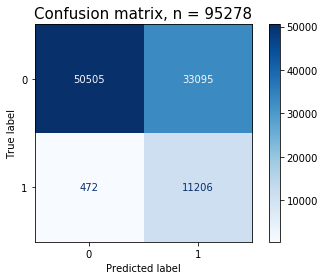

              precision    recall  f1-score   support

           0       0.99      0.60      0.75     83600
           1       0.25      0.96      0.40     11678

    accuracy                           0.65     95278
   macro avg       0.62      0.78      0.58     95278
weighted avg       0.90      0.65      0.71     95278



In [ ]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model1, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

print(classification_report(y_val, y_pred_1))

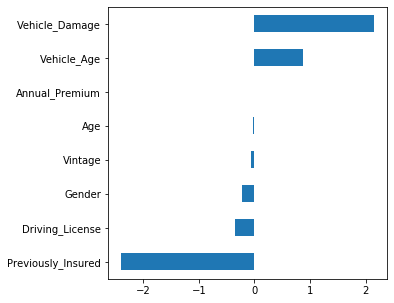

In [ ]:
# 로지스틱 모델의 특성들의 회귀 계수
model_lr = model1.named_steps['logisticregression']
pre = model1.named_steps['ordinalencoder']
encoded_columns = pre.transform(X_val).columns
coefficients = pd.Series(model_lr.coef_[0], encoded_columns)
plt.figure(figsize=(5,5))
coefficients.sort_values().plot.barh();

In [ ]:
# 2. 결정트리모델
model2 = make_pipeline(
    OrdinalEncoder(),  
    DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, random_state=2, class_weight={False:balance[0],True:balance[1]})
)

model2.fit(X_train, y_train)

print('결정트리모델 검증세트 정확도 :', model2.score(X_val, y_val))

결정트리모델 검증세트 정확도 : 0.6785301958479397


In [ ]:
y_pred2 = model2.predict(X_val)
y_pred_proba2 = model2.predict_proba(X_val)[:, -1]
print('결정트리모델 검증세트 AUC score :', roc_auc_score(y_val, y_pred_proba2))
print("결정트리모델 검증세트 F1 score :", f1_score(y_val, y_pred2))
print("결정트리모델 검증세트 재현율 :", recall_score(y_val, y_pred2))

결정트리모델 검증세트 AUC score : 0.8370379725792005
결정트리모델 검증세트 F1 score : 0.4148405708499704
결정트리모델 검증세트 재현율 : 0.9296968659016955


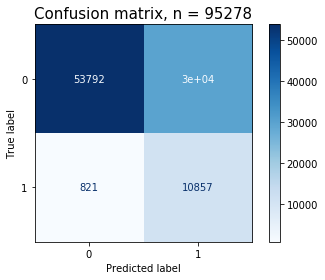

              precision    recall  f1-score   support

           0       0.98      0.64      0.78     83600
           1       0.27      0.93      0.41     11678

    accuracy                           0.68     95278
   macro avg       0.63      0.79      0.60     95278
weighted avg       0.90      0.68      0.73     95278



In [ ]:
# 결정트리모델 confusion matrix

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model2, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

print(classification_report(y_val, y_pred2))

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

pipe1 = Pipeline([
    ('preprocessing', OrdinalEncoder()),
    ('DT', DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, class_weight={False:balance[0],True:balance[1]}, random_state=2)) 
])

{'preprocessing': OrdinalEncoder(),
 'DT': DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, class_weight={False:balance[0],True:balance[1]}, random_state=2)}

pipe1.fit(X_train, y_train)

permuter1 = PermutationImportance(
    pipe1.named_steps['DT'],
    scoring='recall', 
    n_iter=5, 
    random_state=2
)

X_val_transformed = pipe1.named_steps['preprocessing'].transform(X_val)       # 검증세트 인코딩

permuter1.fit(X_val_transformed, y_val);

feature_names1 = X_train.columns.tolist()

# 중요도
pd.Series(permuter1.feature_importances_, feature_names1).sort_values(ascending=False)

Vehicle_Damage        0.447748
Previously_Insured    0.423754
Vintage               0.000000
Annual_Premium        0.000000
Driving_License       0.000000
Gender               -0.000257
Age                  -0.019969
Vehicle_Age          -0.021493
dtype: float64

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter1, 
    top=None,  
    feature_names=feature_names1 
)

Weight,Feature
0.4477 ± 0.0115,Vehicle_Damage
0.4238 ± 0.0071,Previously_Insured
0 ± 0.0000,Vintage
0 ± 0.0000,Annual_Premium
0 ± 0.0000,Driving_License
-0.0003 ± 0.0017,Gender
-0.0200 ± 0.0023,Age
-0.0215 ± 0.0018,Vehicle_Age


In [ ]:
# 중요도가 0보다 큰 특성만 골라 예측
mask = permuter1.feature_importances_ >= 0
features1 = X_train.columns[mask]

X_train_selected1 = X_train[features1]
X_val_selected1 = X_val[features1]
X_test_selected1 = X_test[features1]

pipe1 = Pipeline([
    ('preprocessing', OrdinalEncoder()),
    ('DT', DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, class_weight={False:balance[0],True:balance[1]}, random_state=2)) 
])

pipe1.fit(X_train_selected1, y_train);
y_pred_p1 = pipe1.predict(X_val_selected1)
print('검증 정확도: ', pipe1.score(X_val_selected1, y_val))

y_pred_proba_p1 = pipe1.predict_proba(X_val_selected1)[:, -1]
print("결정트리모델 특성 선택 후 검증세트 AUC score: ", roc_auc_score(y_val, y_pred_proba_p1))
print("결정트리모델 특성 선택 후 검증세트 F1 score :", f1_score(y_val, y_pred_p1))
print("결정트리모델 특성 선택 후 검증세트 재현율 :", recall_score(y_val, y_pred_p1))

검증 정확도:  0.6374504082789312
결정트리모델 특성 선택 후 검증세트 AUC score:  0.7976751135533957
결정트리모델 특성 선택 후 검증세트 F1 score : 0.39783840320753067
결정트리모델 특성 선택 후 검증세트 재현율 : 0.9771364959753382


In [ ]:
# 결정트리 모델 하이퍼파라미터 조정
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

dists1 = {     
    'DT__min_samples_leaf': randint(50, 500), 
    'DT__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

clf1 = RandomizedSearchCV(
    pipe1, 
    param_distributions=dists1, 
    n_iter=40,
    cv=5,
    scoring='recall',    # 평가지표는 재현율
    n_jobs = -1,
    verbose = 1
)

clf1.fit(X_train_selected1, y_train);
print('최적 하이퍼파라미터: ', clf1.best_params_)
print('F1 score: ', clf1.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
최적 하이퍼파라미터:  {'DT__max_depth': 1, 'DT__min_samples_leaf': 194}
F1 score:  0.9787052309869486


In [ ]:
best1 = clf1.best_estimator_    # 가장 성능 좋은 모델
y_pred1_b = best1.predict(X_val_selected1)
y_pred_proba1_b = best1.predict_proba(X_val_selected1)[:, 1]

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba1_b)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# 임계값 구하기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('임계값 :', optimal_threshold)

y_pred_optimal1 = y_pred_proba1_b >= optimal_threshold
y_pred_optimal1 = y_pred_optimal1.astype(int)
from sklearn.metrics import roc_auc_score
print("파라미터 조정 후 검증세트 AUC 점수 :", roc_auc_score(y_val, y_pred_optimal1))
print("파라미터 조정 후 검증세트 F1 score :", f1_score(y_val, y_pred_optimal1))
print("파라미터 조정 후 검증세트 재현율 :", recall_score(y_val, y_pred_optimal1))

임계값 : 0.6907657609244414
파라미터 조정 후 검증세트 AUC 점수 : 0.7697938554153683
파라미터 조정 후 검증세트 F1 score : 0.3819028387376713
파라미터 조정 후 검증세트 재현율 : 0.9797910601130331


In [ ]:
# 3. 랜덤포레스트모델
model3 = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=-1, random_state=2, oob_score=True, class_weight={False:balance[0],True:balance[1]})
)

model3.fit(X_train, y_train)

print('랜덤포레스트모델 검증 정확도: ', model3.score(X_val, y_val))

랜덤포레스트모델 검증 정확도:  0.6736497407586222


In [ ]:
y_pred3 = model3.predict(X_val)
y_pred_proba3 = model3.predict_proba(X_val)[:, -1]
print('랜덤포레스트모델 검증 AUC score :', roc_auc_score(y_val, y_pred_proba3))
print("랜덤포레스트모델 검증세트 F1 score :", f1_score(y_val, y_pred3))
print("랜덤포레스트모델 검증세트 재현율 :", recall_score(y_val, y_pred3))

랜덤포레스트모델 검증 AUC score : 0.8376060084352781
랜덤포레스트모델 검증세트 F1 score : 0.4129219847443547
랜덤포레스트모델 검증세트 재현율 : 0.9363760917965405


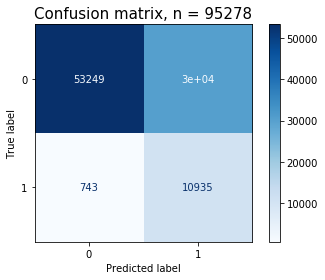

              precision    recall  f1-score   support

           0       0.99      0.64      0.77     83600
           1       0.26      0.94      0.41     11678

    accuracy                           0.67     95278
   macro avg       0.63      0.79      0.59     95278
weighted avg       0.90      0.67      0.73     95278



In [ ]:
# 랜덤포레스트모델 confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model3, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred3))

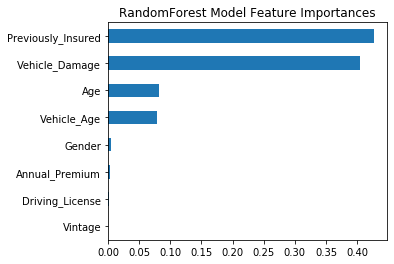

In [ ]:
# 랜덤포레스트모델 특성 중요도
rf_ord = model3.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)
n=len(X_train.columns)
plt.figure(figsize=(5,n/2))
plt.title(f'RandomForest Model Feature Importances')
importances_ord.sort_values()[-n:].plot.barh();

In [ ]:
# 랜덤포레스트 순열 중요도
import eli5
from eli5.sklearn import PermutationImportance

pipe2 = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('RF', RandomForestClassifier(max_depth=5, n_estimators=100, class_weight={False:balance[0],True:balance[1]}, random_state=2, n_jobs=-1)) 
])

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder())]),
 'RF': RandomForestClassifier(max_depth=5, n_estimators=100, class_weight={False:balance[0],True:balance[1]}, random_state=2, n_jobs=-1)}

pipe2.fit(X_train, y_train)

permuter2 = PermutationImportance(
    pipe2.named_steps['RF'],
    scoring='recall', 
    n_iter=10, 
    random_state=2
)

X_val_transformed = pipe2.named_steps['preprocessing'].transform(X_val)       # 검증세트 인코딩

permuter2.fit(X_val_transformed, y_val);

feature_names = X_train.columns.tolist()

# 중요도
pd.Series(permuter2.feature_importances_, feature_names).sort_values(ascending=False)

Vehicle_Damage        0.454067
Previously_Insured    0.427025
Gender                0.000334
Vintage               0.000146
Driving_License      -0.000146
Annual_Premium       -0.000771
Age                  -0.017623
Vehicle_Age          -0.018847
dtype: float64

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter2, 
    top=None,  
    feature_names=feature_names 
)

Weight,Feature
0.4541 ± 0.0118,Vehicle_Damage
0.4270 ± 0.0082,Previously_Insured
0.0003 ± 0.0021,Gender
0.0001 ± 0.0004,Vintage
-0.0001 ± 0.0002,Driving_License
-0.0008 ± 0.0008,Annual_Premium
-0.0176 ± 0.0018,Age
-0.0188 ± 0.0022,Vehicle_Age


In [ ]:
# 중요도가 0보다 큰 특성만 골라 예측
mask = permuter2.feature_importances_ > 0
features2 = X_train.columns[mask]

X_train_selected2 = X_train[features2]
X_val_selected2 = X_val[features2]
X_test_selected2 = X_test[features2]

pipe2 = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('RF', RandomForestClassifier(max_depth=5, n_estimators=100, class_weight={False:balance[0],True:balance[1]}, random_state=2, n_jobs=-1)) 
])

pipe2.fit(X_train_selected2, y_train);
y_pred_p2 = pipe2.predict(X_val_selected2)
print('검증 정확도: ', pipe2.score(X_val_selected2, y_val))

y_pred_proba_p2 = pipe2.predict_proba(X_val_selected2)[:, -1]
print('랜덤포레스트모델 특성 선택 후 검증세트 AUC score: ', roc_auc_score(y_val, y_pred_proba_p2))
print("랜덤포레스트모델 특성 선택 후 검증세트 F1 score :", f1_score(y_val, y_pred_p2))
print("랜덤포레스트모델 특성 선택 후 검증세트 재현율 :", recall_score(y_val, y_pred_p2))

검증 정확도:  0.6366737337055773
랜덤포레스트모델 특성 선택 후 검증세트 AUC score:  0.79495274720142
랜덤포레스트모델 특성 선택 후 검증세트 F1 score : 0.3974936907144722
랜덤포레스트모델 특성 선택 후 검증세트 재현율 : 0.9778215447850659


In [ ]:
# 랜덤포레스트 모델 하이퍼파라미터 조정
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

dists2 = {     
    'RF__n_estimators': randint(100, 500), 
    'RF__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

clf2 = RandomizedSearchCV(
    pipe2, 
    param_distributions=dists2, 
    n_iter=30,
    cv=4,
    scoring='recall',    # 평가지표는 재현율
    n_jobs = -1,
    verbose = 1
)

clf2.fit(X_train_selected2, y_train);
print('최적 하이퍼파라미터 :', clf2.best_params_)
print('재현율 :', clf2.best_score_)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
최적 하이퍼파라미터 : {'RF__max_depth': 8, 'RF__n_estimators': 481}
재현율 : 0.9769068280429322


In [ ]:
best2 = clf2.best_estimator_    # 가장 성능 좋은 모델
y_pred2_b = best2.predict(X_val_selected2)
y_pred_proba2_b = best2.predict_proba(X_val_selected2)[:, 1]

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba2_b)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# 임계값 구하기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('임계값 :', optimal_threshold)

y_pred_optimal2 = y_pred_proba2_b >= optimal_threshold
y_pred_optimal2 = y_pred_optimal2.astype(int)

print("파라미터 조정 후 검증세트 AUC 점수 :", roc_auc_score(y_val, y_pred_optimal2))
print("파라미터 조정 후 검증세트 F1 score :", f1_score(y_val, y_pred_optimal2))
print("파라미터 조정 후 검증세트 재현율 :", recall_score(y_val, y_pred_optimal2))

임계값 : 0.6763839669028203
파라미터 조정 후 검증세트 AUC 점수 : 0.7834203417705234
파라미터 조정 후 검증세트 F1 score : 0.3974936907144722
파라미터 조정 후 검증세트 재현율 : 0.9778215447850659


In [ ]:
# 4. XGBoost 모델
model4 = make_pipeline(
    OrdinalEncoder(), 
    XGBClassifier(max_depth=20, n_estimators=1000, class_weight={False:balance[0],True:balance[1]}, random_state=2)
)

model4.fit(X_train, y_train)

print('XGBoost 모델 검증 정확도: ', model4.score(X_val, y_val))

XGBoost 모델 검증 정확도:  0.8652889439324923


In [ ]:
from sklearn.metrics import roc_auc_score
y_pred4 = model4.predict(X_val)
y_pred_proba4 = model4.predict_proba(X_val)[:, -1]
print('XGBoost 모델 AUC score: ', roc_auc_score(y_val, y_pred_proba4))
print("XGBoost 모델 검증세트 F1 score :", f1_score(y_val, y_pred4))
print("XGBoost 모델 검증세트 재현율 :", recall_score(y_val, y_pred4))    # 재현율이 너무 낮음

XGBoost 모델 AUC score:  0.8249557985776224
XGBoost 모델 검증세트 F1 score : 0.13795419437168377
XGBoost 모델 검증세트 재현율 : 0.0879431409487926


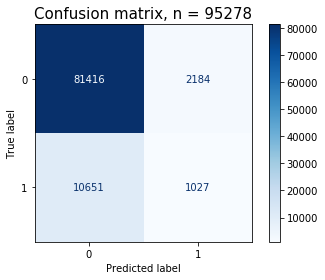

              precision    recall  f1-score   support

           0       0.88      0.97      0.93     83600
           1       0.32      0.09      0.14     11678

    accuracy                           0.87     95278
   macro avg       0.60      0.53      0.53     95278
weighted avg       0.82      0.87      0.83     95278



In [ ]:
# XGBoost모델 confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model4, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred4))      

# 아닌 사람을 아닌걸로 예측하는 것만 정확하다

### 모델 선택
---
### 1. 로지스틱 회귀모델
* AUC score : 0.81189
* F1 score : 0.40036
* 재현율 : 0.95958

### 2. 결정트리모델 
* AUC score : 0.83703
* F1 score : 0.41484
* 재현율 : 0.92969

#### 특성 선택 후
* AUC score:  0.79767
* F1 score : 0.39783  
* 재현율 : 0.97713

#### 파라미터 조정 후 ✔️
* AUC score : 0.76979
* F1 score : 0.38190
* **재현율 : 0.97979**

### 3. 랜덤포레스트모델 
#### 기준 모델
* AUC score :  0.83760
* F1 score :  0.41292
* 재현율 : 0.93637

#### 특성 선택 후
* AUC score:  0.79495
* F1 score : 0. 39749
* 재현율 : 0.97782

#### 파라미터 조정 후
* AUC score : 0.78342 
* F1 score : 0.39749
* 재현율 : 0.97782

### 4. XGBoost 모델
* AUC score:  0.82495
* F1 score : 0.13795
* 재현율 : 0.08794
---

왜 기본모델 중 LogisticRegressor의 성능이 가장 좋은가?  
XGB의 성능이 너무 낮게 나오는가?







### 최종모델(결정트리모델) 

# **테스트데이터 재현율 : 0.98030**

In [ ]:
# 최종모델로 예측
X_train_F = X_train_F[features1]
X_test_F = X_test[features1]

best1.fit(X_train_F, y_train_F)
y_pred_t = best1.predict(X_test_F)
y_pred_proba_t = best1.predict_proba(X_test_F)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_t)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# 임계값 구하기
optimal_idx_t = np.argmax(tpr - fpr)
optimal_threshold_t = thresholds[optimal_idx_t]
print('임계값 :', optimal_threshold_t)

y_pred_optimal_t = y_pred_proba_t >= optimal_threshold_t
y_pred_optimal_t = y_pred_optimal_t.astype(int)
print("테스트세트 AUC 점수 :", roc_auc_score(y_test, y_pred_optimal_t))
print("테스트세트 F1 score :", f1_score(y_test, y_pred_optimal_t))
print("테스트세트 재현율 :", recall_score(y_test, y_pred_optimal_t)) 

임계값 : 0.6905759435844013
테스트세트 AUC 점수 : 0.7686614763682433
테스트세트 F1 score : 0.3805961879432624
테스트세트 재현율 : 0.9803054088768375


## 4) PDP plot / SHAP  시각화

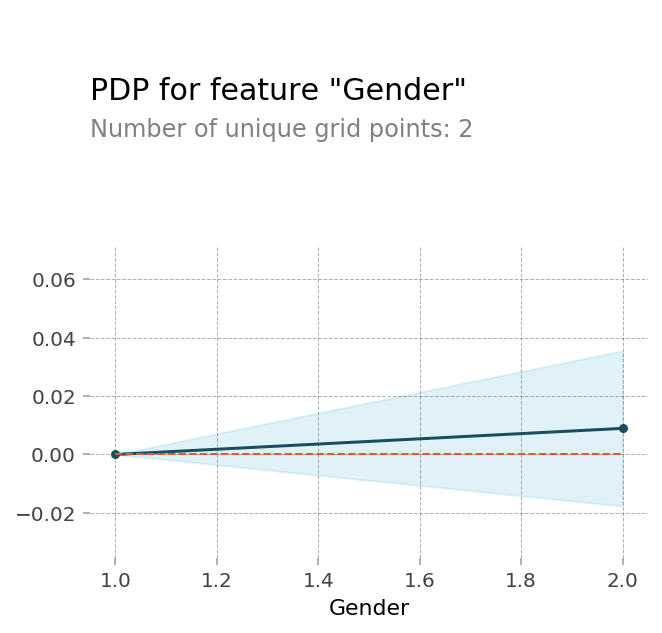

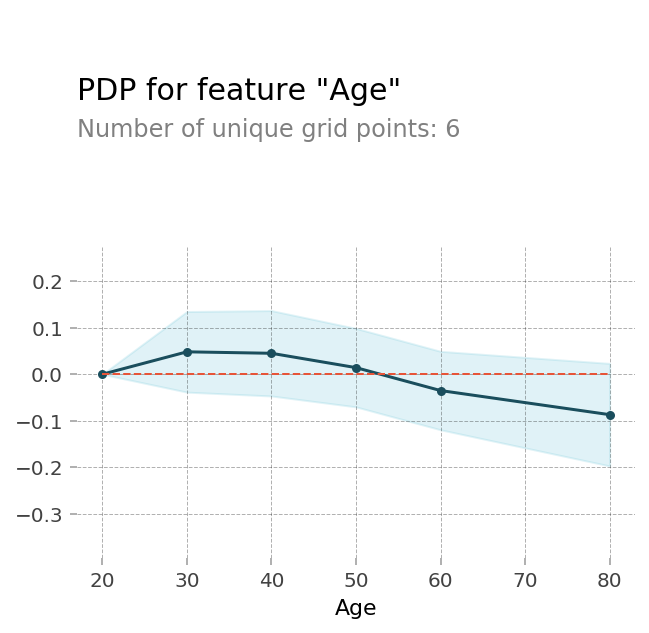

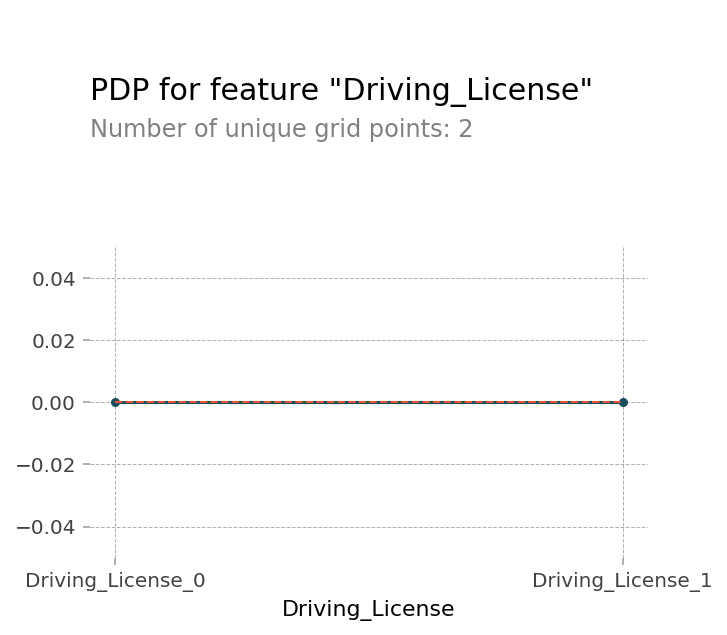

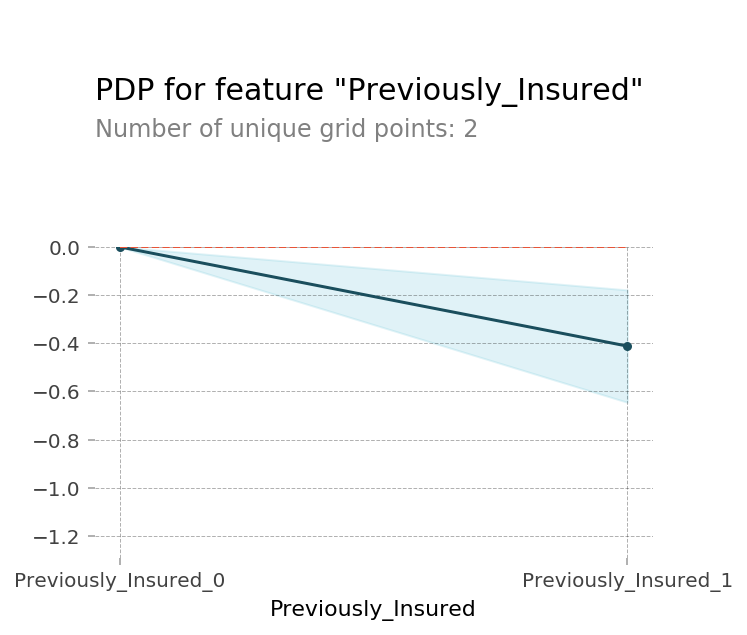

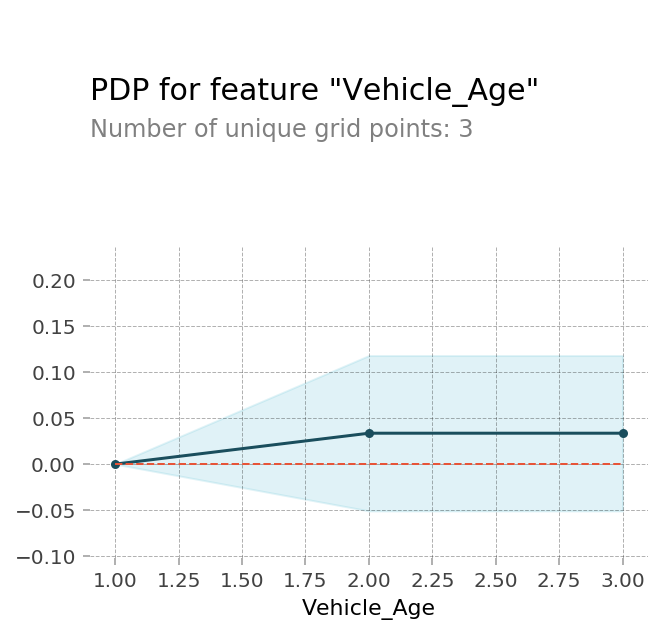

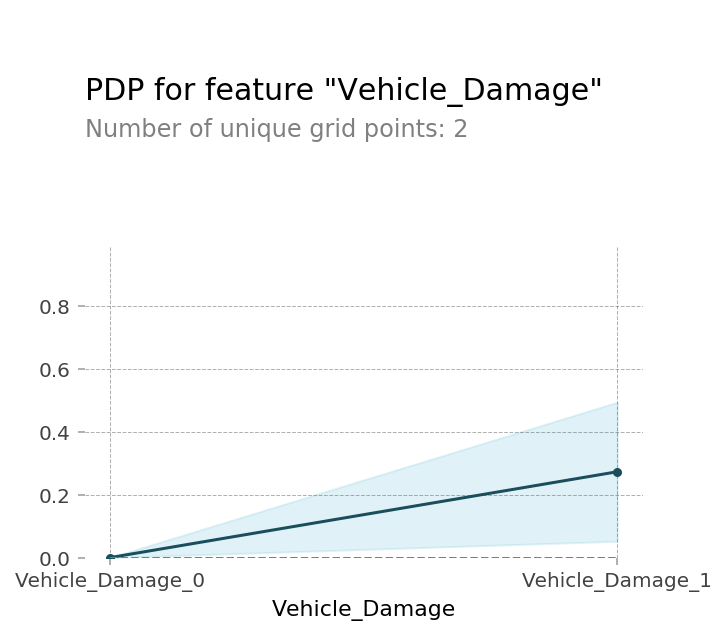

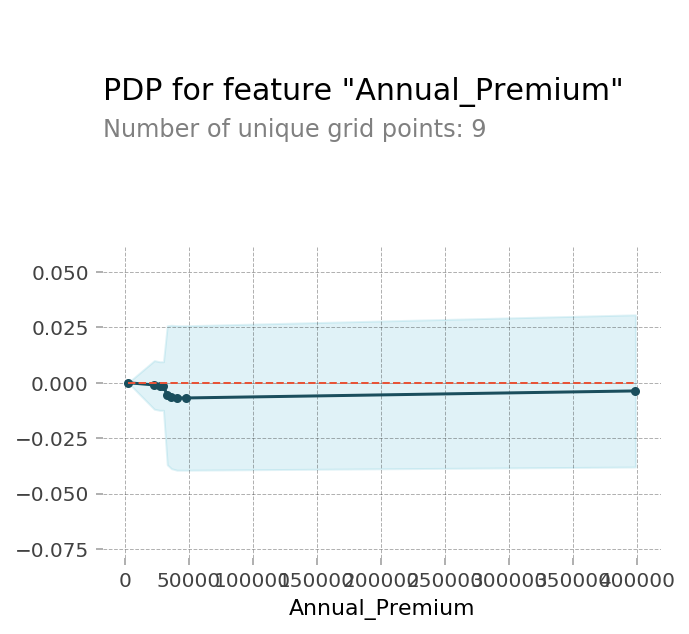

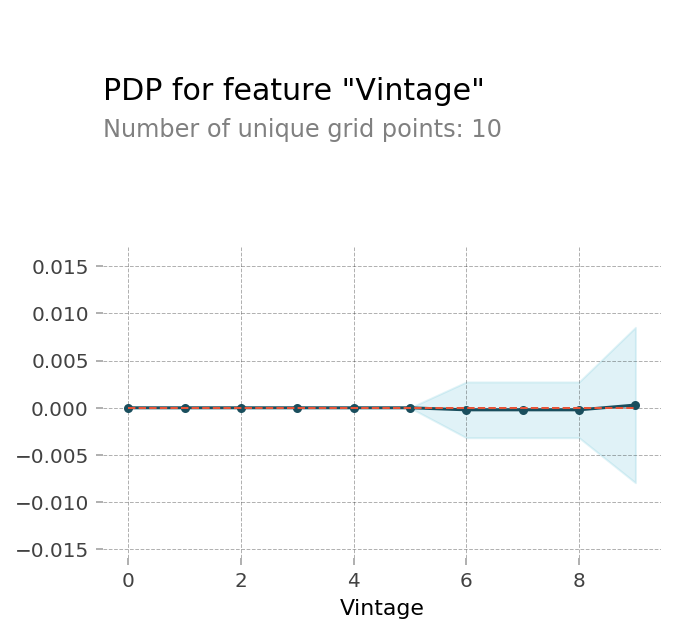

In [ ]:
# 시각화
import sklearn
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144
from pdpbox.pdp import pdp_isolate, pdp_plot

pipe = Pipeline([
    ('preprocessing', OrdinalEncoder()),
    ('DT', DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, class_weight={False:balance[0],True:balance[1]}, random_state=2)) 
])

encoder = pipe.named_steps['preprocessing']

X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

tree = pipe.named_steps['DT']

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

tree.fit(X_train_encoded, y_train)

feature = X_train_encoded.columns

for i in range(len(feature)):
  isolated = pdp_isolate(
      model=tree, 
      dataset=X_test_encoded, 
      model_features=X_test_encoded.columns,
      feature=feature[i]
  )
  pdp_plot(isolated, feature_name=feature[i], figsize=(5, 5));

**가설 : pdp plot을 보아 Annual_Premium(고객이 내야하는 보험금)은 차량보험 가입여부에 영향이 거의 없다는 것을 알 수 있다**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


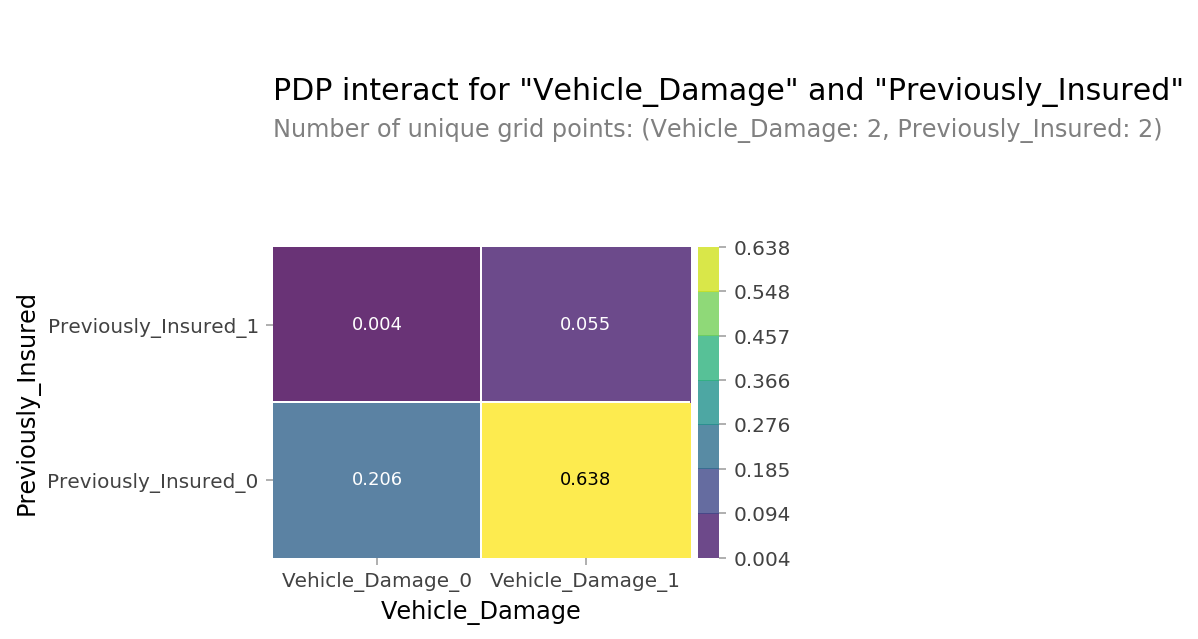

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Vehicle_Damage', 'Previously_Insured']

interaction = pdp_interact(
    model=tree, 
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features, figsize=(4, 5));

In [ ]:
!pip install pdpbox
!pip install shap
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import shap
shap.initjs()

encoder = pipe.named_steps['preprocessing']
X_train_encoded = encoder.fit_transform(X_train)   # 학습데이터
X_val_encoded = encoder.transform(X_val)           # 검증데이터
X_test_encoded = encoder.transform(X_test)         # 테스트데이터

tree = pipe.named_steps['DT']

tree.fit(X_train_encoded, y_train)

row = X_train_encoded.iloc[[11]]

explainer = shap.TreeExplainer(tree)
row_encoded = encoder.transform(row)
shap_values = explainer.shap_values(row_encoded)

In [ ]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit' 
)

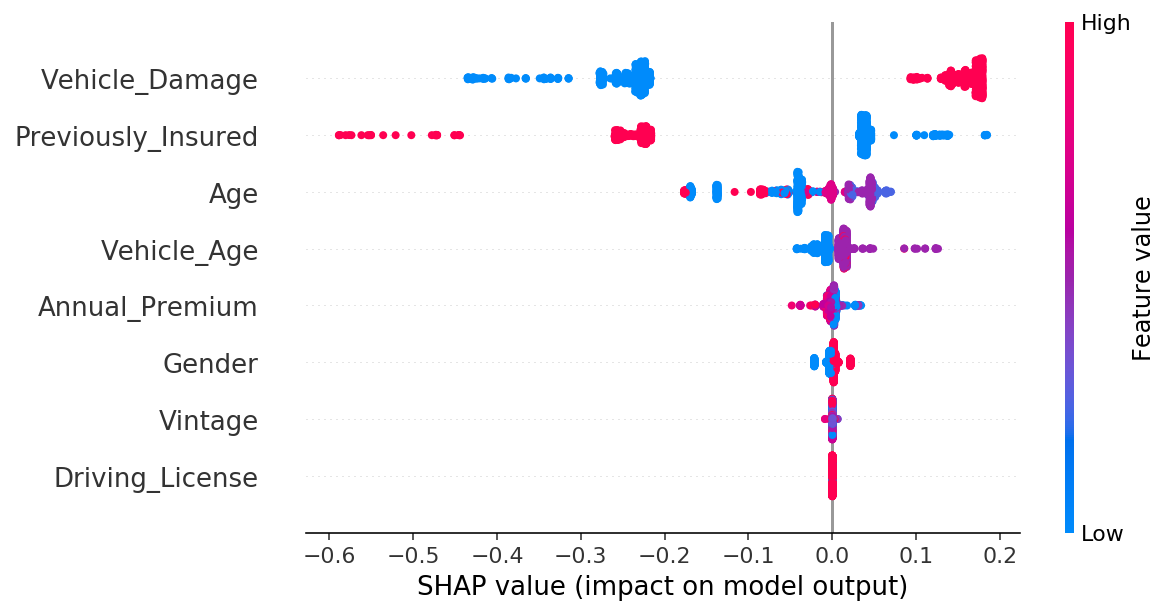

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_train_encoded.iloc[:1000])
shap.summary_plot(shap_values[1], X_train_encoded.iloc[:1000])

## 5) 결과

1. Previously_Insured : 차량보험이 있는 사람이 1(High) 없는 사람이 0(Low)여서  
차량 보험이 없는 사람 0(Low)이 모델 성능을 높이는 영향을 준다
2. Vehicle_Damage : 차량 파손 경험이 있는 사람이 1(High) 없는 사람이 0(Low)여서  
경험이 있는 사람이 1(High) 성능을 높인다
3. Age : 연령대별로 나눴을 때 보라색인 40대 정도에서 모델 성능을 높인다.  
너무 나이가 많거나 어린사람은 모델 성능을 낮춘다